## Task 1

author: 25-AI-张杰郗

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as ds
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import spacy
import matplotlib.pyplot as plt

### 数据预处理+模型定义

In [6]:
raw_train = pd.read_json("./game-chat/game_chat_train.jsonl", lines=True)
raw_test = pd.read_json("./game-chat/game_chat_validation.jsonl", lines=True)

In [7]:
raw_train.head()

,sentence,label,idx
0,浩出不,买卖账号,0
1,谁有3星10，卖我点,正常,1
2,为了领红，包跟手，机,买卖账号,2
3,你红包和手机***,买卖账号,3
4,你的领到手机了吗,买卖账号,4


In [8]:
print("train:", raw_train["label"].value_counts())
print("test:", raw_test["label"].value_counts())

name2id = {name: i for i, name in enumerate(raw_train['label'].unique())}
id2name = {i: name for name, i in name2id.items()}

train: label
买卖账号    1176
正常       600
拉人       592
辱骂         8
色情         2
Name: count, dtype: int64
test: label
买卖账号    1160
正常       625
拉人       584
辱骂         9
色情         4
Name: count, dtype: int64


我们使用spacy库对词进行tokenizer+embedding

In [9]:
tokenizer = spacy.load("zh_core_web_sm")

train_data = [np.stack([token.vector for token in tokenizer(sentence)]) for sentence in raw_train['sentence'].tolist()]
train_labels = [name2id[label] for label in raw_train['label'].tolist()]

test_data = [np.stack([token.vector for token in tokenizer(sentence)]) for sentence in raw_test['sentence'].tolist()]
test_labels = [name2id[label] for label in raw_test['label'].tolist()]

In [10]:
print(train_data[0].shape)

(2, 96)


In [11]:
class Dataset(ds.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_fn(batch):
    data, labels = zip(*batch)
    max_len = max([d.shape[0] for d in data])
    padded_data = [np.pad(d, ((0, max_len - d.shape[0]), (0, 0)), 'constant') for d in data]
    padded_data = torch.tensor(padded_data, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_data, labels

In [12]:
torch.manual_seed(1114514)

dataset = Dataset(train_data, train_labels)
dataloader = ds.DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

test_dataset = Dataset(test_data, test_labels)
test_dataloader = ds.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, hidden_size=128, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(96, hidden_size, num_layers, batch_first=True, dropout= 0 if num_layers == 1 else dropout)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 5)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(dropout)

        return

    def forward(self, x:torch.Tensor):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.relu(self.fc1(out[:, -1, :]))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)

        return self.softmax(out)

### 模型训练

In [29]:
torch.manual_seed(1114514)

epoches = 300
loss_cache = []

model = LSTMClassifier(hidden_size=128, num_layers=4, dropout=0.5).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(epoches):
    total_loss = 0

    for data, labels in dataloader:
        data, labels = data.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    loss_cache.append(total_loss / len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

Epoch 1, Loss: 1.601343420346578
Epoch 2, Loss: 1.42691916624705
Epoch 3, Loss: 1.4114952452977498
Epoch 4, Loss: 1.4112783940633138
Epoch 5, Loss: 1.4132181803385417
Epoch 6, Loss: 1.409427965482076
Epoch 7, Loss: 1.414823112487793
Epoch 8, Loss: 1.4119994529088338
Epoch 9, Loss: 1.4100720087687175
Epoch 10, Loss: 1.411199787457784
Epoch 11, Loss: 1.409318151473999
Epoch 12, Loss: 1.4105439933141073
Epoch 13, Loss: 1.408320943514506
Epoch 14, Loss: 1.4067494265238445
Epoch 15, Loss: 1.409943814277649
Epoch 16, Loss: 1.4023895851771038
Epoch 17, Loss: 1.362163831392924
Epoch 18, Loss: 1.337095996538798
Epoch 19, Loss: 1.2981496524810792
Epoch 20, Loss: 1.2798544263839722
Epoch 21, Loss: 1.2835053888956707
Epoch 22, Loss: 1.300909980138143
Epoch 23, Loss: 1.2770047489802043
Epoch 24, Loss: 1.2738870477676392
Epoch 25, Loss: 1.2954405546188354
Epoch 26, Loss: 1.2710135475794475
Epoch 27, Loss: 1.2671370458602906
Epoch 28, Loss: 1.2571120278040568
Epoch 29, Loss: 1.253963465690613
Epoch 3

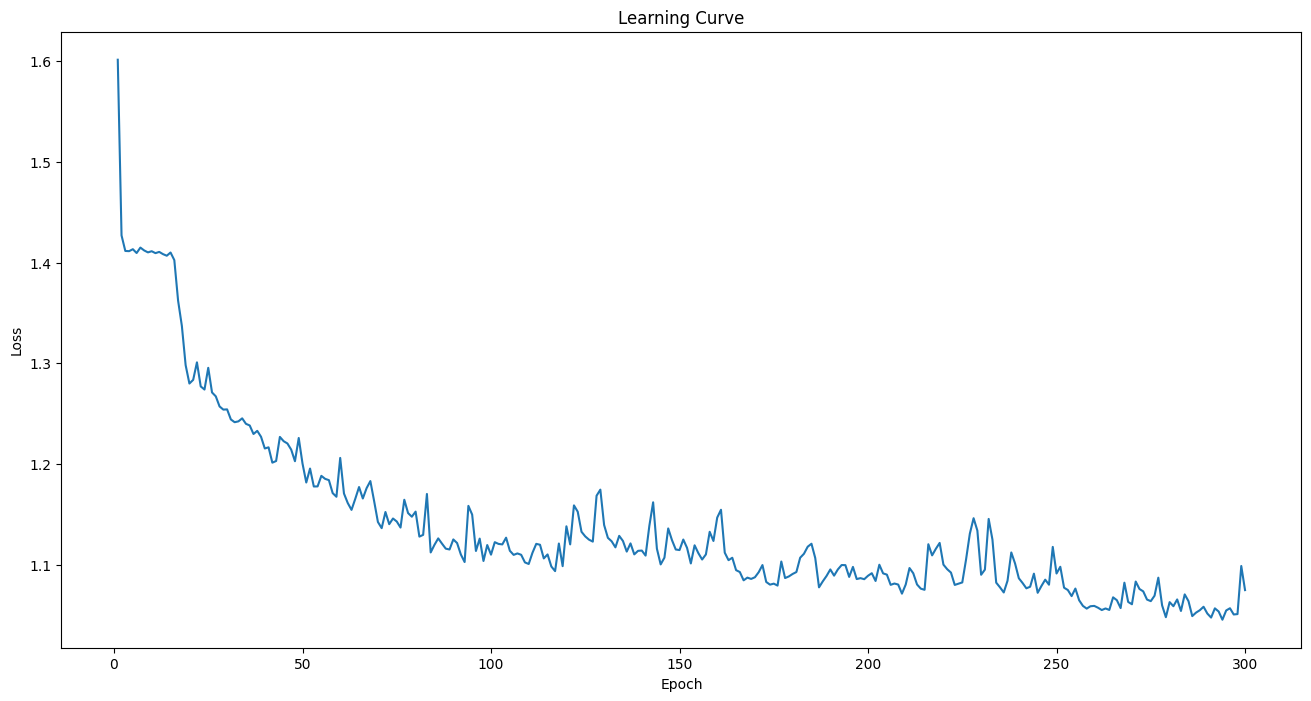

In [30]:
plt.figure(figsize=(16, 8))
plt.plot(range(1, epoches + 1), loss_cache)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

LSTM learning curve:
![lstm](./images/lstm_classifier-4-0.5.png "lstm learning curve")

In [ ]:
torch.save(model, "./models/task1/lstm_classifier-4-0.5.pth")

### 模型评估

In [14]:
model = torch.load("./models/task1/lstm_classifier-4-0.5.pth", weights_only=False)
model.eval()

preds = []
for data, labels in test_dataloader:
    data, labels = data.cuda(), labels.cuda()
    outputs = model(data)
    outputs = torch.argmax(outputs, dim=1)
    preds.extend(outputs.tolist())

test_true = raw_test['label'].map(lambda x: name2id[x]).tolist()
acc = metrics.accuracy_score(test_true, preds)
precision = metrics.precision_score(test_true, preds, average='macro')
recall = metrics.recall_score(test_true, preds, average='macro')
f1 = metrics.f1_score(test_true, preds, average='macro')
print("-"*60, "\n", f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1-score: {f1}", "\n", "-"*60)

C:\Users\zhang\AppData\Local\Temp\ipykernel_20020\1843371094.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  padded_data = torch.tensor(padded_data, dtype=torch.float32)


------------------------------------------------------------ 
 Accuracy: 0.7317380352644837, Precision: 0.43147335256795627, Recall: 0.4244763155408597, F1-score: 0.42683093654391213 
 ------------------------------------------------------------


d:\python\39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


由`UndefinedMetricWarning`警告可知，由于训练数据标签分布的极度不均衡，所以导致模型并没有学习到3和4类。